# Random Forest Classification of protein-kinase cancer links

This notebook takes as input the data on Clinical Trials (according to year and phase) and embedded vectors that represent words and concepts in PubMed. It uses data collected up to a certain year (refered to as target year in the code, e.g., 2010), uses this data to train a Random Forest model, and assess how well the model predicts protein kinase - cancer links in future years. See the manuscript for details on the methods. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, recall_score, average_precision_score, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetDatasetGenerator, KcetRandomForest

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035 Download the five files to a local directory and enter the path of this directory in the following input dialog

- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt
- clinical_trials_by_phase.tsv


To run this notebook, download all of these files to the same directory and enter the path to the directory after running the ``input()`` command.

In [2]:
download_dir = input()

 /home/peter/data/pubmed2vec


In [3]:
ctfile = os.path.join(download_dir, "clinical_trials_by_phase.tsv")
embeddings = os.path.join(download_dir, "embedding_SG_dim100_upto2010.npy")
words =  os.path.join(download_dir, "words_SG_upto2010.txt")
if not os.path.isfile(ctfile):
    raise FileNotFoundError("Could not find clinical trials file at %s" % ctfile)
if not os.path.isfile(embeddings):
    raise FileNotFoundError("Could not find 2010 embeddings file at %s" % embeddings)
if not os.path.isfile(words):
    raise FileNotFoundError("Could not find 2010 words file at %s" % words)    

### Display receiver operating characteristics (ROC) curve
The following function adds a single ROC curve to a matplotlib axis object.

In [4]:
def plot_one_auc_curve(axis, y_test, yproba, begin_year: int, end_year: int, n_pos_test):
    fpr, tpr, thresholds_auc = roc_curve(y_test,  yproba)
    auc_roc = roc_auc_score(y_test, yproba)
    axis.plot(fpr, tpr, label='%d-%d (%0.2f), n=%d' %(begin_year, end_year, auc_roc, n_pos_test))
    return auc_roc

### Display precision recall (PR) curve
The following function adds a single PR curve to a matplotlib axis object. 

In [5]:
def plot_one_precision_recall_curve(axis, y_test, y_pred, begin_year: int, end_year: int, n_pos_test):
    """
    Plot a single precision recall curve
    axis: a matplotlib axis
    y_test: a numpy.ndarray with known classes
    y_pred: a numpy.ndarray with predictions
    midyear: an integer -- the start year for our predictions
    num_years_later: an integer -- how many years after midyear to go
    n_pos_test: number of true examples that are positive
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)

    auc_recall_precision = average_precision_score(y_test, y_pred)
    
    my_label = '%d-%d, (%0.2f), n=%d' % (begin_year, end_year, auc_recall_precision, n_pos_test)
    axis.plot(recall, precision, label=my_label)
    f1_scores = 2*recall*precision/(recall+precision)
    # some nan values are encountered. The following replaces NaN by 0.0
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold =  thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)
    precision_at_threshold = precision_score(y_test, y_pred > best_threshold)
    recall_at_threshold = recall_score(y_test, y_pred > best_threshold)
    return best_threshold, best_f1, precision_at_threshold, recall_at_threshold

In [6]:
datagen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words)

[INFO] Reading protein kinase information from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 698 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 698 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 76 entries
2021-09-18 21:11:48,464 - kcet.pk_pki_filter - INFO - Reading PK/PKI data from /home/peter/GIT/KCET/input/DrugCentralPKIPK.csv
2021-09-18 21:11:48,503 - kcet.pk_pki_filter - INFO - Ingested 2460 pk pki links with Kd data
2021-09-18 21:11:48,506 - kcet.pk_pki_filter - INFO - Processing abemaciclib
2021-09-18 21:11:48,507 - kcet.pk_pki_filter - INFO - PKI: abemaciclib, number of inhibited PKs 2
2021-09-18 21:11:48,508 - kcet.pk_pki_filter - INFO - Processing acalabrutinib
2021-09-18 21:11:48,509 - kcet.pk_pki_filter - INFO - PKI: acalabrutinib, number of inhibited PKs 2
2021-09-1

Iterations: .....

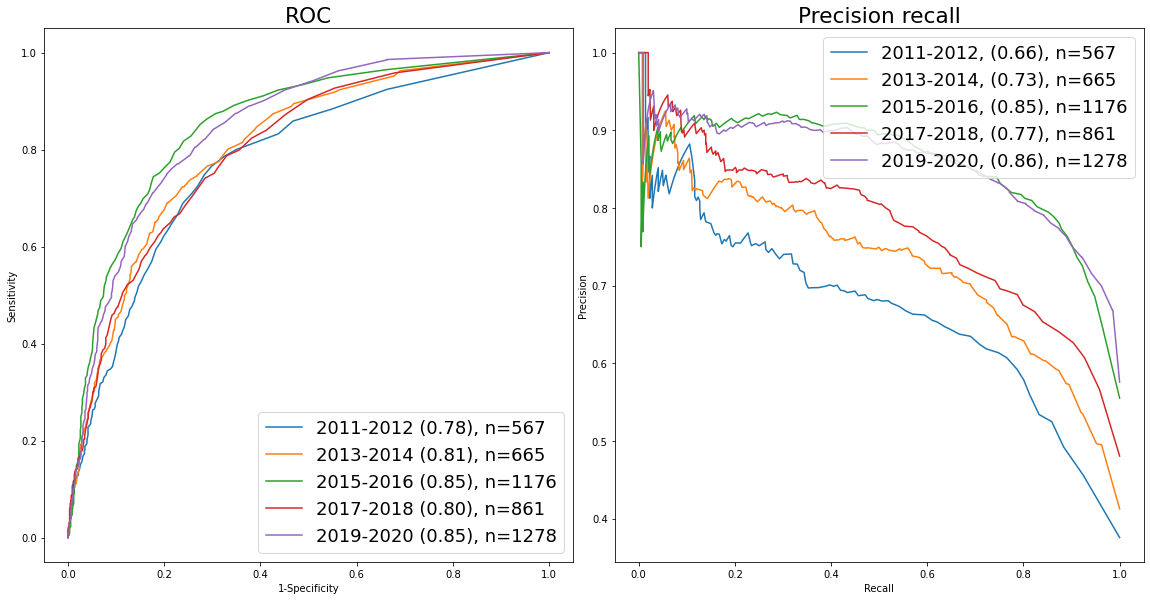

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout()
font = {'family' :'normal', 'size': 18}
matplotlib.rc('font', **font)

targetyear = 2010
prediction_years= [(2011,2012), (2013,2014), (2015,2016), (2017,2018), (2019,2020)]

krf = KcetRandomForest(data_gen=datagen, target=targetyear, embedddingfile=embeddings, wordsfile=words)

pr_data = []

print("Iterations: ", end='')
for (begin_y, end_y) in prediction_years:
    print(".", end = '')
    y_pred, y_test, yproba, n_pos_test = krf.classify(begin_year=begin_y, end_year=end_y)
    # print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = plot_one_auc_curve(ax1, y_test, yproba, begin_y, end_y, n_pos_test)
    thresh, fscore, precision_at_threshold, recall_at_threshold = plot_one_precision_recall_curve(ax2, y_test, yproba, begin_y, end_y, n_pos_test)
    pr_data.append({"start": begin_y, 
                    "end": end_y,
                    "AUROC": auc_roc,
                    "threshold": thresh, 
                    "f-score": fscore, 
                    "precision@threshold": precision_at_threshold, 
                    "recall@threshold": recall_at_threshold,
                    "n_pos_test": n_pos_test})
# show this below with results for P/R analysis
pr_df = pd.DataFrame(pr_data)
    
     
ax1.set_title('ROC');
ax1.set_xlabel('1-Specificity');
ax1.set_ylabel('Sensitivity');
ax1.legend(loc="lower right");
ax2.set_title('Precision recall');
ax2.set_xlabel('Recall');
ax2.set_ylabel('Precision');
ax2.legend(loc="lower left");   

# Summary
The threshold refers to the threshold probability at which the highest F1 score was obtained for the precision recall analysis. 
The remaining two columns show the precision and recall at these thresholds.
The analysis was performed for different combinations of years following the target year of 2010.

In [8]:
pr_df

,start,end,AUROC,threshold,f-score,precision@threshold,recall@threshold,n_pos_test
0,2011,2012,0.773404,0.032500,0.657856,0.564394,0.788360,567
1,2013,2014,0.804973,0.035000,0.702918,0.636139,0.772932,665
2,2015,2016,0.855128,0.030263,0.815625,0.754158,0.886905,1176
3,2017,2018,0.784816,0.025000,0.734694,0.663227,0.821138,861
4,2019,2020,0.846122,0.030000,0.828829,0.776860,0.882629,1278
